<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CervejaGratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For the Netxt

* Adaptar o `creatdataset` com o `.float()` e com dados de teste
* Arrumar a ordem do código pq ta uma bagunça né?


# LSTM Básica


Fonte:
https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
#np.random.seed(42)
sns.set_style('darkgrid')

#Functions

In [96]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    data_train_X.append(dataset_train[i:(i+window_in), 0])
    data_train_Y.append(dataset_train[i + window_in:i + window_in + window_ou, 0])

    data_test_X.append(dataset_test[i:(i+window_in), 0])
    data_test_Y.append(dataset_test[i + window_in:i + window_in + window_ou, 0])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_)
  plt.plot(y2)    

In [2]:
print(torch.__version__)

1.12.1+cu113


# gerando dados sintéticos

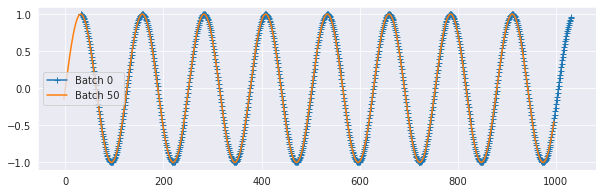

In [127]:
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize=(10,3))
plt.plot(x[0],y[0], marker='+',label="Batch 0")
plt.plot(x[50],y[50],label="Batch 50")
plt.legend()
plt.show()

In [22]:
print(y.shape)
print(x.shape)

(100, 1000)
(100, 1000)


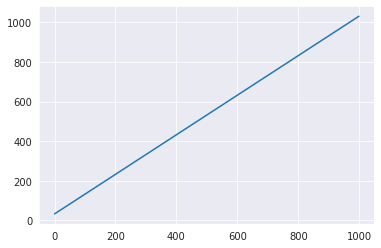

In [131]:
plt.figure()
plt.plot(x[0])
plt.show()

# Arquitetura da rede

1 entrada 1 saida por vez

In [15]:
class A():
  def __init__(self, b):
    self.a = b
    self._privado()

  def _privado(self):
    print(self.a)

obj = A(5)
obj2 = A(6)


5
6


In [ ]:
a = 3
self.a = 3

In [ ]:
novo = [[1,2,3],[1,2,3],[1,1,2]]

In [24]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=32):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        h_t = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs


In [25]:
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)

In [26]:
test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)

# Model

In [27]:
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)

In [31]:
def training_loop(n_epochs, model, optimiser, loss_fn,  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        

        with torch.no_grad():
            future = 1000
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        #plt.savefig("predict%d.png"%i, dpi=200)
        plt.show()
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

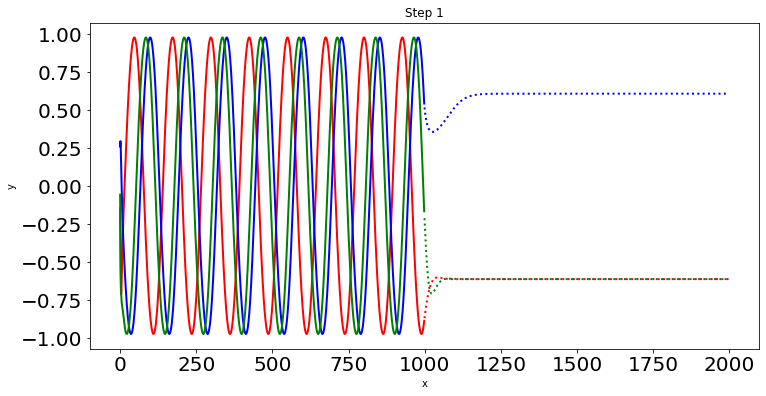

Step: 0, Loss: 0.000983522622846067


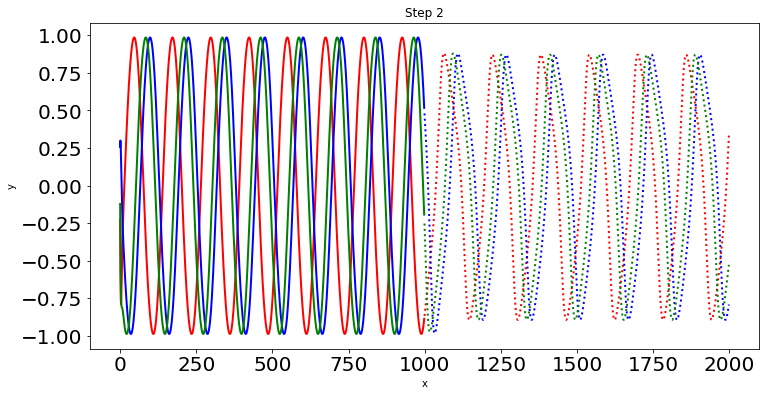

Step: 1, Loss: 0.0004367406654637307


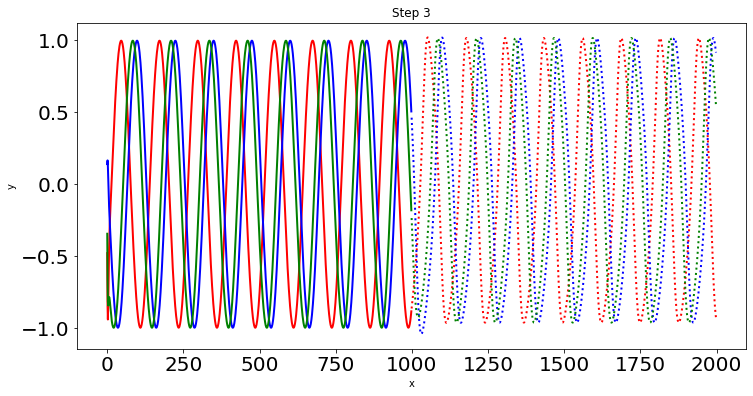

Step: 2, Loss: 0.0002253523125546053


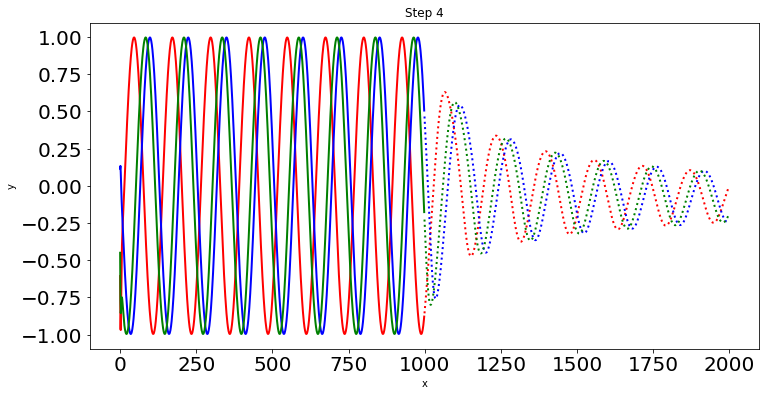

Step: 3, Loss: 0.00018325368000660092


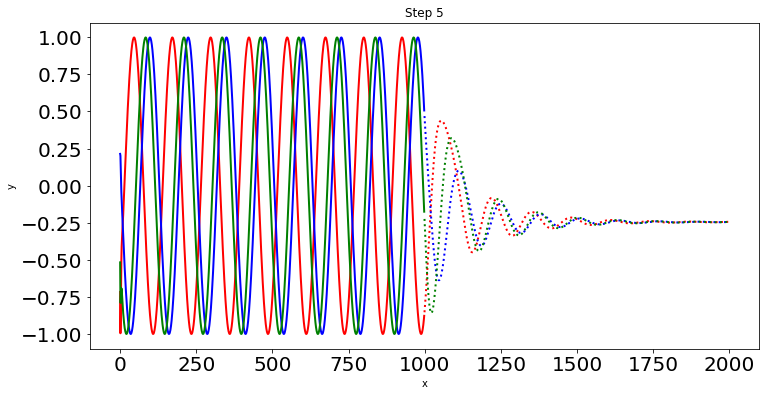

Step: 4, Loss: 0.00013510054850485176


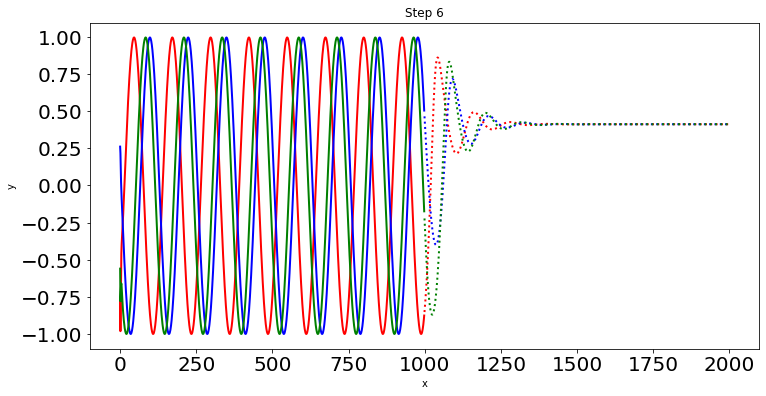

Step: 5, Loss: 0.00012210680870339274


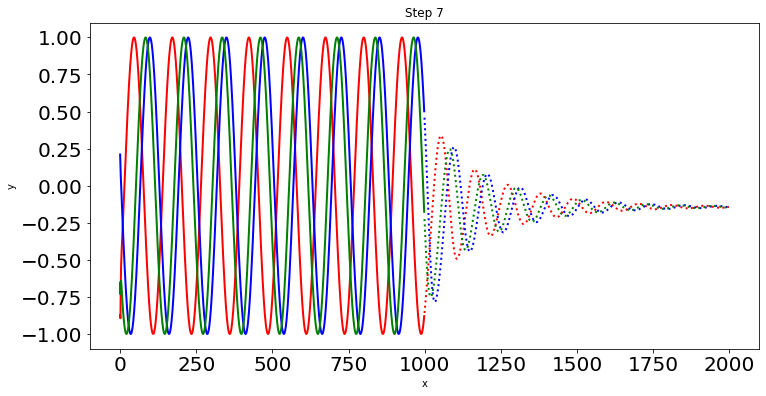

Step: 6, Loss: 6.373043288476765e-05


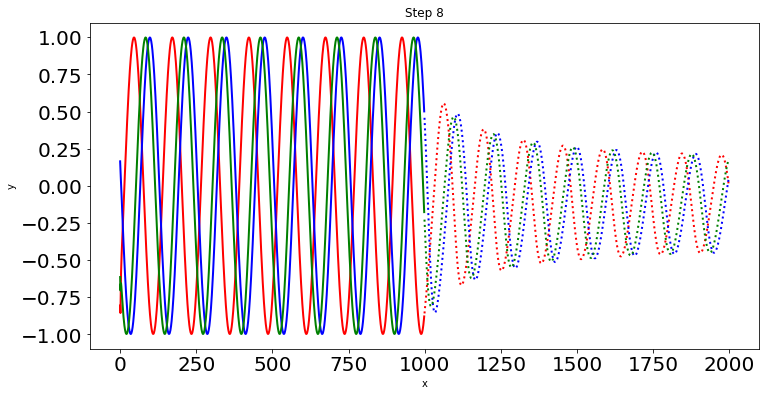

Step: 7, Loss: 4.067575355293229e-05


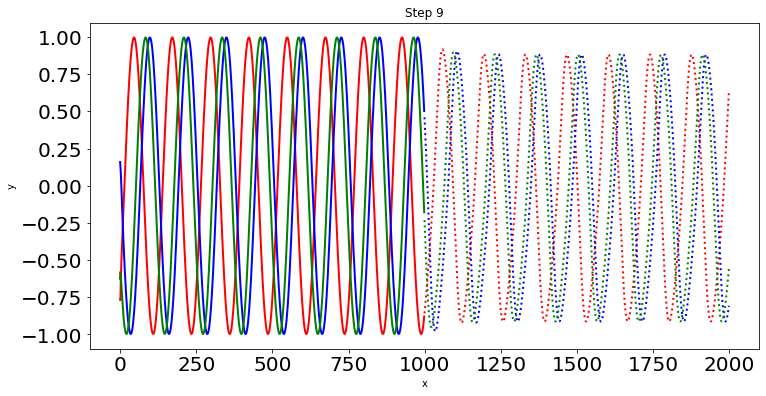

Step: 8, Loss: 2.746897007455118e-05


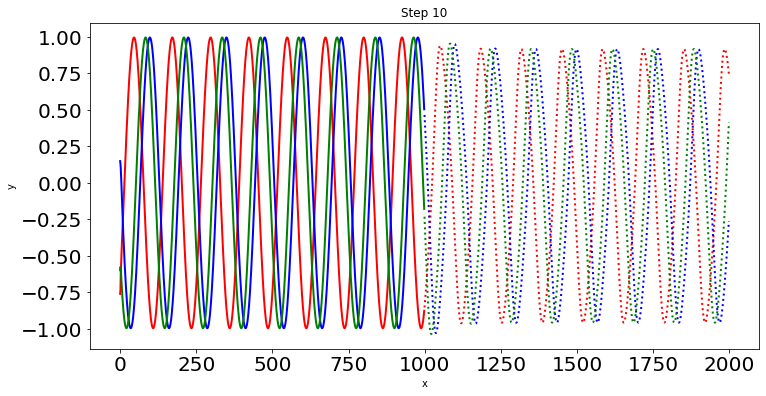

Step: 9, Loss: 2.371088157815393e-05


In [33]:
training_loop(10, model, optimiser, nn.MSELoss(), train_input, train_target, test_input, test_target)

# Exemplo de funcao de custo

https://blog.paperspace.com/pytorch-loss-functions/

In [122]:
class Custom_MSE(nn.Module):
  def __init__(self):
    super(Custom_MSE, self).__init__();

  def forward(self, predictions, target):
    square_difference = torch.square(predictions - target)
    loss_value = torch.mean(square_difference)
    return loss_value

  def __call__(self, predictions, target):
    square_difference = torch.square(predictions - target)
    loss_value = torch.mean(square_difference)
    return loss_value

In [ ]:
model = LSTM()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
l = Custom_MSE()
training_loop(10, model, optimiser, l, train_input, train_target, test_input, test_target)

Step: 0, Loss: 0.06844275444746017
Step: 1, Loss: 0.02025131694972515
Step: 2, Loss: 0.00637619337067008
Step: 3, Loss: 0.0010366548085585237
Step: 4, Loss: 0.0004129421431571245
Step: 5, Loss: 0.00030579694430343807
Step: 6, Loss: 0.00019430746033322066
Step: 7, Loss: 0.00014425281551666558
Step: 8, Loss: 0.00011755209561670199
Step: 9, Loss: 9.422650327906013e-05


# Calculo do beta

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [42]:
class DBeta(nn.Module):
  def __init__(self):
    super(DBeta, self).__init__();

  def beta(self,vet):
    ft = torch.fft.fft(vet,dim =1)
    ft = ft*torch.conj(ft)
    psd = torch.real(ft)
    freq = torch.fft.fftfreq(vet.size(dim=1))
    freq = freq.repeat(psd.size(dim=0),1)

    # remove frequencias negativas e zero
    freq = freq[:,1:vet.size(dim=1)//2]
    psd = psd[:,1:vet.size(dim=1)//2]

    #passa para escala log
    #print(freq.size())
    freq = torch.log(freq)
    psd = torch.log(psd)
    
    #print(psd.size(dim=0))

    # calcula o angulo do ajuste linear
    b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
    #print(vet.size(), b.size())
    
    return b
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

In [67]:
trainX, trainY, trainX_test, trainY_test = torch.tensor(trainX), torch.tensor(trainY), torch.tensor(trainX_test), torch.tensor(trainY_test)

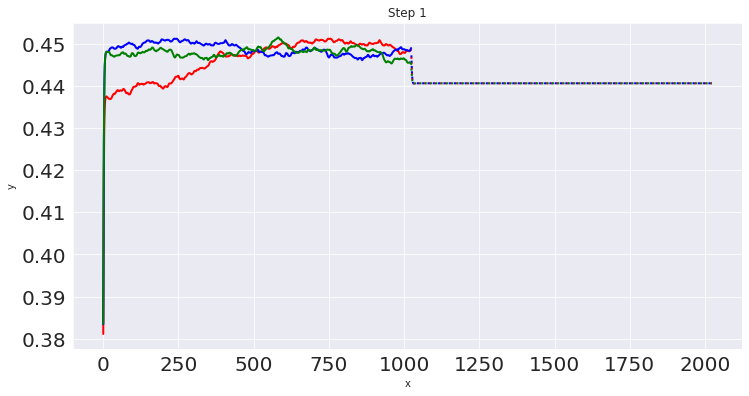

Step: 0, Loss: 0.05912468582391739


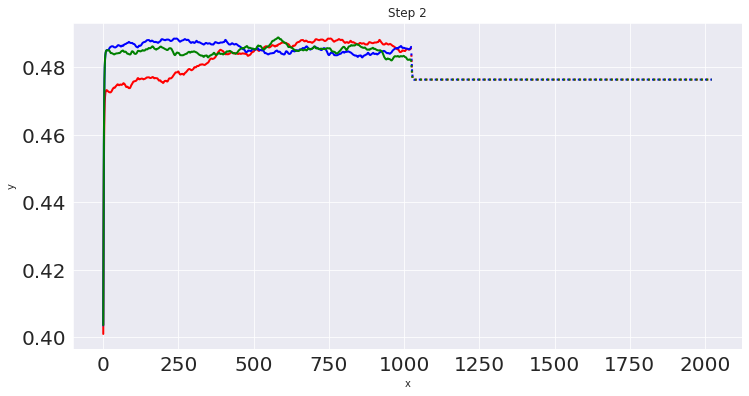

Step: 1, Loss: 0.057479746639728546


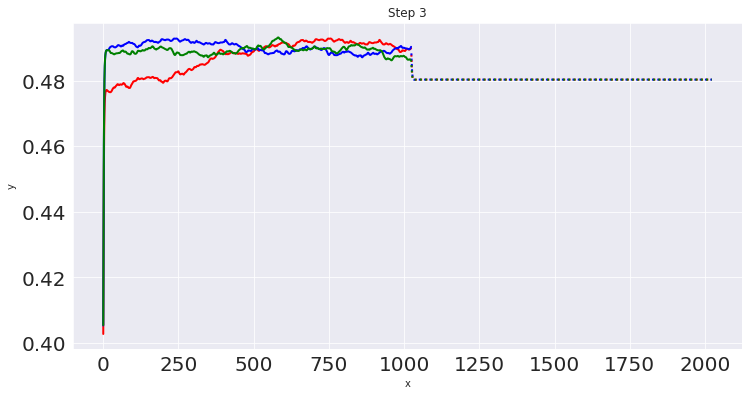

Step: 2, Loss: 0.057458795607089996


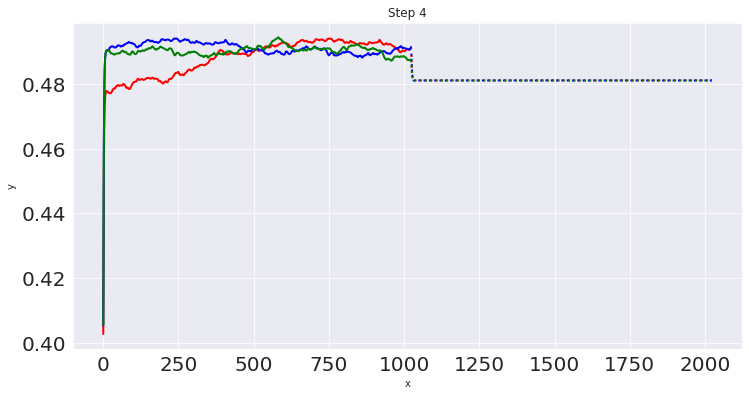

Step: 3, Loss: 0.0574580617249012


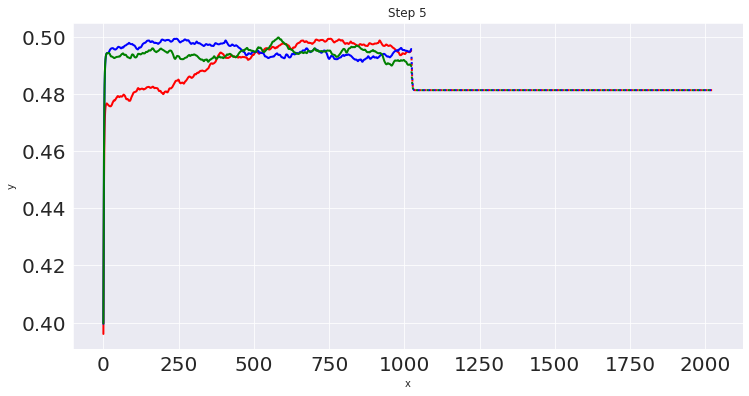

Step: 4, Loss: 0.05745378136634827


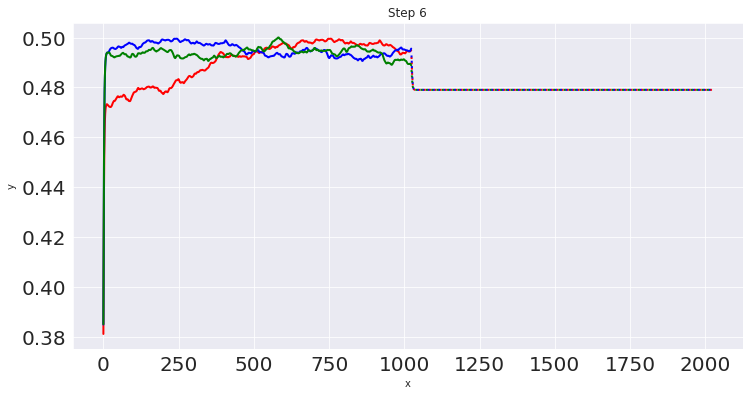

Step: 5, Loss: 0.05744680017232895


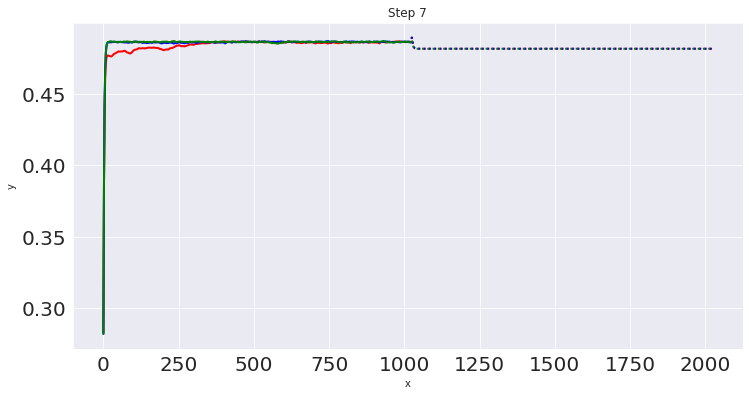

Step: 6, Loss: 0.05741242319345474


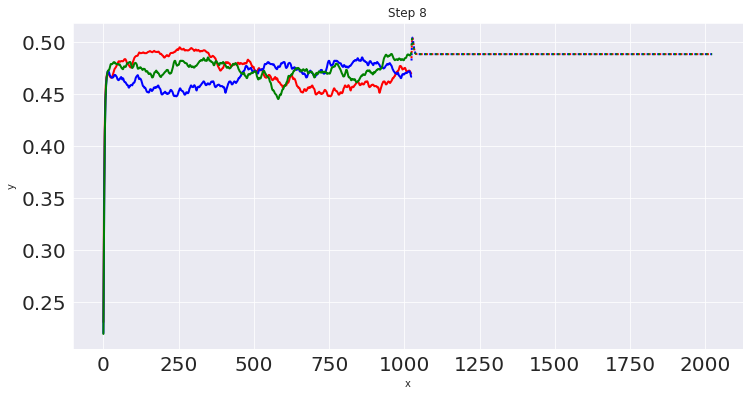

Step: 7, Loss: 0.05727183818817139


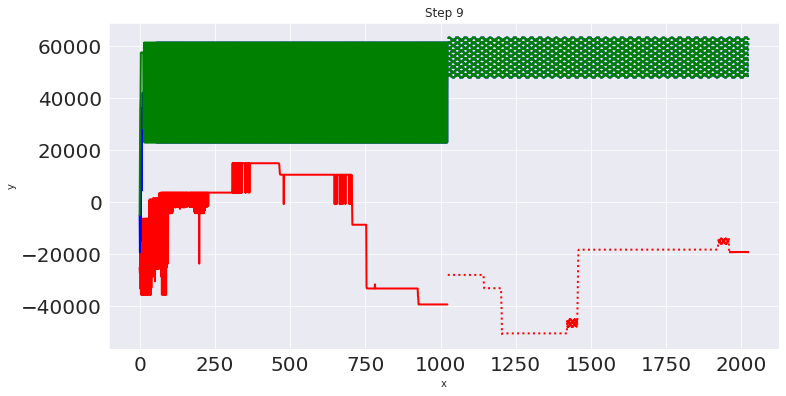

Step: 8, Loss: 232573344.0


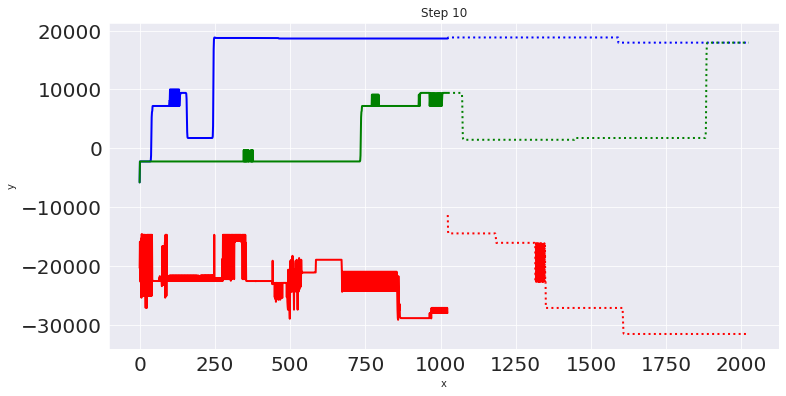

Step: 9, Loss: 387191072.0


In [124]:
model = LSTM()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
l = DBeta()
training_loop(10, model, optimiser, nn.MSELoss(), trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float())

In [35]:
!pip install colorednoise
import colorednoise as cn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
trainX.shape

torch.Size([5, 1024])

In [115]:
bet = 0
samples = 2**13

wn = cn.powerlaw_psd_gaussian(0, samples)
pn = cn.powerlaw_psd_gaussian(1, samples)
rn = cn.powerlaw_psd_gaussian(2, samples)

def norm(data):
  scaler = MaxAbsScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2

wn1,wn2 = norm(wn)
pn1,pn2 = norm(pn)
rn1,rn2 = norm(rn)  


In [117]:
bet = 0
samples = 1024
win_in = 1024
win_ou = 1024
jump = 512

dataset = rn2
#trainX,trainY = create_dataset(dataset,win_in,win_ou,jump)
trainX, trainY, trainX_test,trainY_test = create_dataset(dataset,win_in,win_ou,jump)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


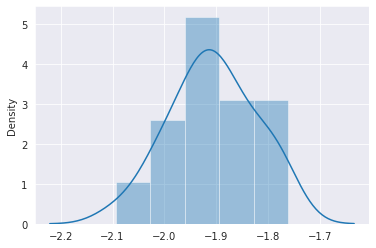

In [104]:
sns.distplot(DBeta().beta(trainX))

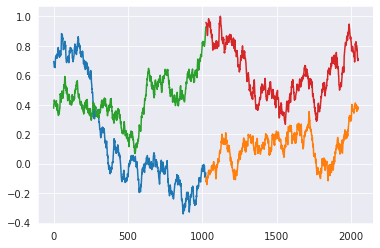

In [107]:
plot_test(trainX[0],trainY[0])
plot_test(trainX_test[0],trainY_test[0])

 

In [56]:
l = DBeta()
beta_test_wn = l.beta( torch.tensor(trainX))


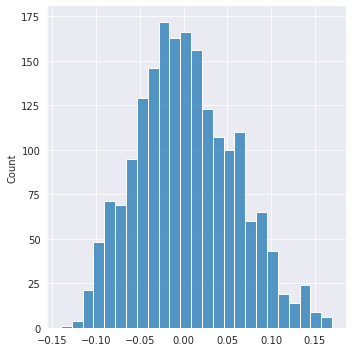

In [60]:
sns.displot(beta_test)